Setup and Data Loading

In [24]:
# Core data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,  RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, f1_score

# Imbalanced-learn and pipeline
from imblearn.over_sampling import SMOTE # 👈 Using standard SMOTE
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SKLearnPipeline

# Load the dataset
try:
    df = pd.read_csv('generated_dataset.csv')
except FileNotFoundError:
    print("Error: The file 'generated_dataset.csv' was not found.")


# Define the target variable 'leak_status' based on a threshold
threshold = 0.25
df['leak_status'] = np.where(df['CR-corrosion defect'] >= threshold, 'Leak', 'No Leak')

# Display the first few rows to confirm changes
display(df.head())

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect,leak_status
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245,No Leak
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262,No Leak
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305,No Leak
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303,No Leak
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202,No Leak


Exploratory Data Analysis

Missing values in each column:
 Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
CR-corrosion defect                        0
leak_status                                0
dtype: int64

Summary statistics:
        Wellhead Temp. (C)  Wellhead Press (psi)    MMCFD- gas  \
count        10292.000000          10292.000000  10292.000000   
mean            57.352401           1361.783583      8.851533   
std              9.423529            559.275420      4.968737   
min             41.070000            382.080000      0.230000   
25%             49.220000            880.000000      4.570000   
50%             57.360000           1364.900000      8.880000   
75%             65.412500   

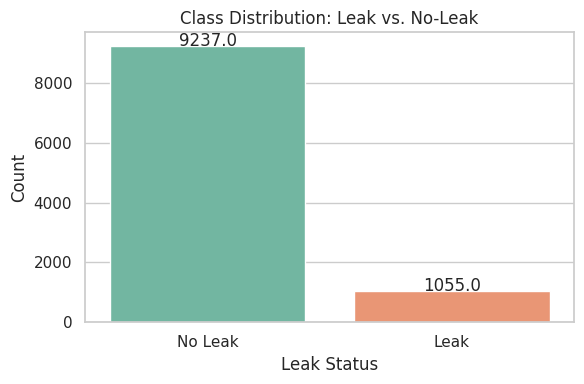

In [25]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Summary statistics of numerical columns
print("\nSummary statistics:\n", df.describe())

# Class distribution
class_distribution = df['leak_status'].value_counts(normalize=True) * 100
print("\nClass distribution (in %):\n", class_distribution)

# Visualizing the class distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='leak_status', hue='leak_status', palette='Set2', legend=False)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height}', ha="center")
plt.title('Class Distribution: Leak vs. No-Leak')
plt.xlabel('Leak Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Data Preprocessing And Splitting

In [26]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['leak_status'])

# Drop the original numerical target and the threshold-based column
X = df.drop(['CR-corrosion defect', 'leak_status'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8233, 8), y_train shape: (8233,)
X_test shape: (2059, 8), y_test shape: (2059,)


Baseline Model Performance Without Smote

In [27]:
print("--- Evaluating Baseline Model (WITHOUT SMOTE) ---")

# Define the cross-validation strategy
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline without a resampling step or a scaler
# RandomForest is a tree-based model and does not require feature scaling.
no_smote_pipeline = SKLearnPipeline([
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        bootstrap=True,
        random_state=42
    ))
])

# Calculate cross-validation scores using f1 as the metric
no_smote_scores = cross_val_score(
    estimator=no_smote_pipeline,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1
)

# Print the results
print(f"\nBaseline F1 Scores for each fold: {np.round(no_smote_scores, 4)}")
print(f"Mean Baseline F1 Score: {np.mean(no_smote_scores):.4f} +/- {np.std(no_smote_scores):.4f}")



--- Evaluating Baseline Model (WITHOUT SMOTE) ---



Baseline F1 Scores for each fold: [0.9607 0.9582 0.9616 0.9597 0.9641]
Mean Baseline F1 Score: 0.9608 +/- 0.0020



--- Evaluating Baseline Model on Test Set ---


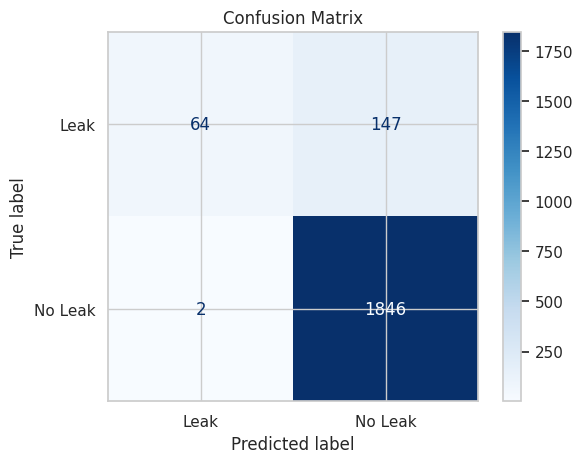

,precision,recall,f1-score,support
Leak,0.97,0.30,0.46,211.00
No Leak,0.93,1.00,0.96,1848.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.95,0.65,0.71,2059.00
weighted avg,0.93,0.93,0.91,2059.00


In [28]:
print("\n--- Evaluating Baseline Model on Test Set ---")

# Fit the pipeline on the training data
no_smote_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = no_smote_pipeline.predict(X_test)

# Evaluate the model
ConfusionMatrixDisplay.from_estimator(no_smote_pipeline, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(2)
display(df_report)

--- Generating Learning Curve ---


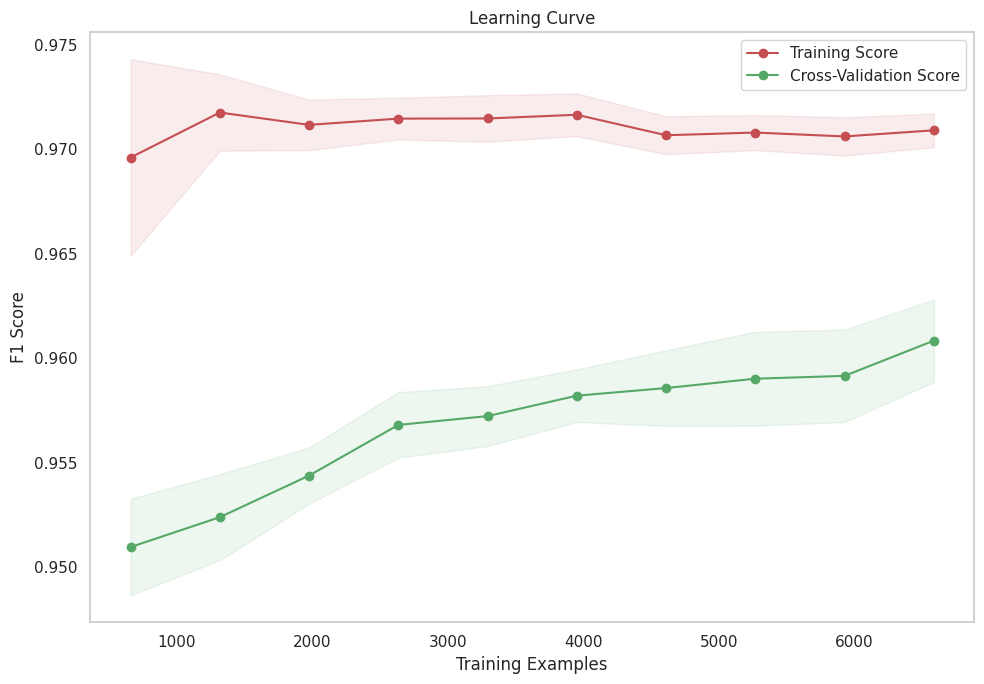

In [29]:
from sklearn.model_selection import learning_curve

print("--- Generating Learning Curve ---")

train_sizes, train_scores, val_scores = learning_curve(
    estimator=no_smote_pipeline,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')

plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

Baseline Model Performance With Smote


--- Evaluating Model (WITH SMOTE) before tuning ---
F1 Scores with SMOTE for each fold: [0.9466 0.9479 0.9448 0.9408 0.9469]
Mean F1 Score with SMOTE: 0.9454 +/- 0.0025


/tmp/ipykernel_33649/580950294.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


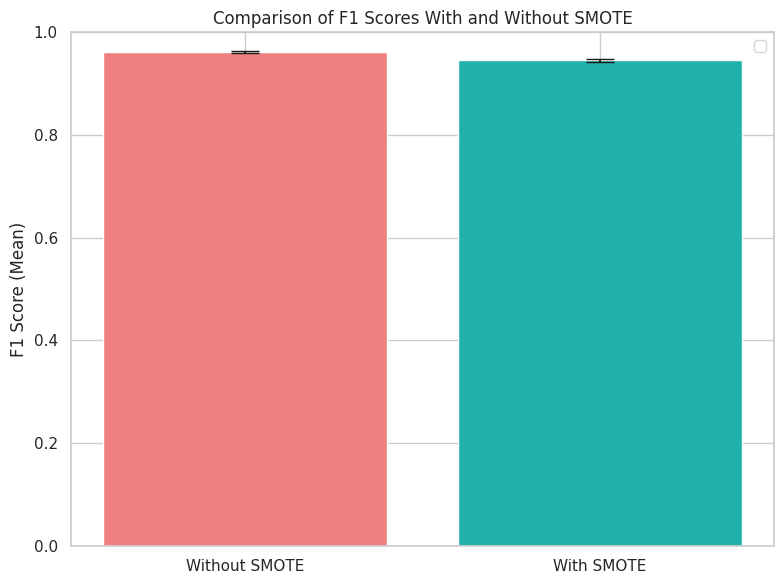


Conclusion: The use of SMOTE did not significantly improve the model's performance on the training data.


In [30]:
print("\n--- Evaluating Model (WITH SMOTE) before tuning ---")

# Define the pipeline with a standard SMOTE step
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        bootstrap=True,
        random_state=42
    ))
])

# Calculate cross-validation scores
smote_scores = cross_val_score(
    estimator=smote_pipeline,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1
)

# Print and visualize the comparison
print(f"F1 Scores with SMOTE for each fold: {np.round(smote_scores, 4)}")
print(f"Mean F1 Score with SMOTE: {np.mean(smote_scores):.4f} +/- {np.std(smote_scores):.4f}")

# Plotting the comparison
labels = ['Without SMOTE', 'With SMOTE']
mean_scores = [np.mean(no_smote_scores), np.mean(smote_scores)]
std_devs = [np.std(no_smote_scores), np.std(smote_scores)]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, mean_scores, yerr=std_devs, capsize=10, color=['lightcoral', 'lightseagreen'])
plt.title('Comparison of F1 Scores With and Without SMOTE')
plt.ylabel('F1 Score (Mean)')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

if np.mean(smote_scores) > np.mean(no_smote_scores):
    print("\nConclusion: The use of SMOTE significantly improved the model's performance on the training data.")
else:
    print("\nConclusion: The use of SMOTE did not significantly improve the model's performance on the training data.")


--- Evaluating Model (with smote) on Test Set ---


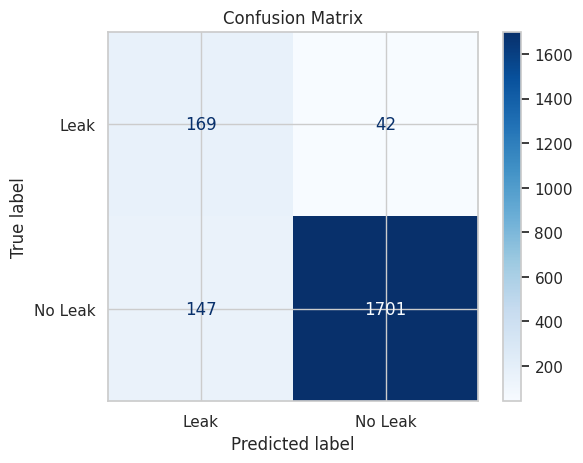

,precision,recall,f1-score,support
Leak,0.53,0.80,0.64,211.00
No Leak,0.98,0.92,0.95,1848.00
accuracy,0.91,0.91,0.91,0.91
macro avg,0.76,0.86,0.79,2059.00
weighted avg,0.93,0.91,0.92,2059.00


In [31]:
print("\n--- Evaluating Model (with smote) on Test Set ---")

# Fit the pipeline on the training data
smote_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = smote_pipeline.predict(X_test)

# Evaluate the model
ConfusionMatrixDisplay.from_estimator(smote_pipeline, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(2)
display(df_report)

--- Generating Learning Curve ---


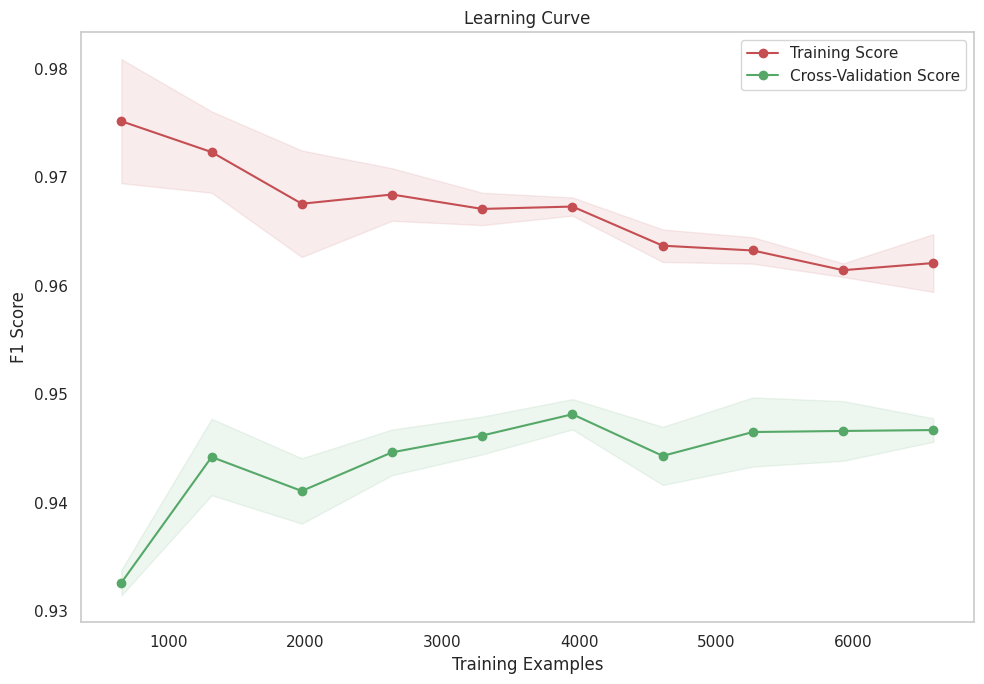

In [32]:
from sklearn.model_selection import learning_curve

print("--- Generating Learning Curve ---")

train_sizes, train_scores, val_scores = learning_curve(
    estimator=smote_pipeline,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')

plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

Hyperparameter Tuning with RandomizedSearchCV

In [33]:


print("--- Starting Hyperparameter Tuning with RandomizedSearchCV ---")

# Define the parameter distributions for the search
param_distributions = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_leaf': [1, 2, 4, 6],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy']
}

# RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=smote_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv_folds,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("\nRandomized Search Best Parameters:", random_search.best_params_)
print(f"Randomized Search Best F1 Score: {random_search.best_score_:.4f}")

--- Starting Hyperparameter Tuning with RandomizedSearchCV ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits



Randomized Search Best Parameters: {'rf__n_estimators': 400, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__criterion': 'entropy', 'rf__bootstrap': False}
Randomized Search Best F1 Score: 0.9694


F1 Scores with SMOTE for each fold: [0.9667 0.9707 0.9638 0.9704 0.9752]
Mean F1 Score with SMOTE and tuned params: 0.9694 +/- 0.0039


/tmp/ipykernel_33649/549421410.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


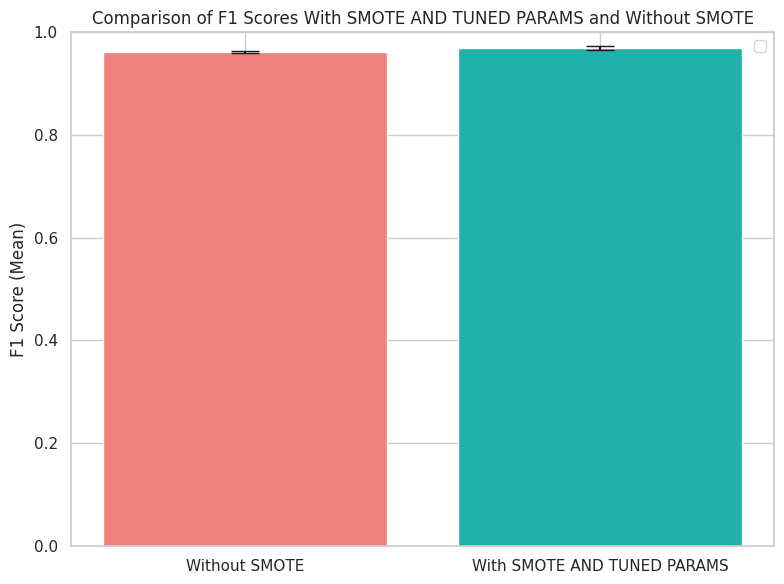


Conclusion: The use of SMOTE AND TUNED PARAMS significantly improved the model's performance on the training data.


In [41]:
# Retrieve the best model from the random search
best_model = random_search.best_estimator_

# Calculate cross-validation scores
smote_scores = cross_val_score(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1
)

# Print and visualize the comparison
print(f"F1 Scores with SMOTE for each fold: {np.round(smote_scores, 4)}")
print(f"Mean F1 Score with SMOTE and tuned params: {np.mean(smote_scores):.4f} +/- {np.std(smote_scores):.4f}")

# Plotting the comparison
labels = ['Without SMOTE', 'With SMOTE AND TUNED PARAMS']
mean_scores = [np.mean(no_smote_scores), np.mean(smote_scores)]
std_devs = [np.std(no_smote_scores), np.std(smote_scores)]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, mean_scores, yerr=std_devs, capsize=10, color=['lightcoral', 'lightseagreen'])
plt.title('Comparison of F1 Scores With SMOTE AND TUNED PARAMS and Without SMOTE')
plt.ylabel('F1 Score (Mean)')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

if np.mean(smote_scores) > np.mean(no_smote_scores):
    print("\nConclusion: The use of SMOTE AND TUNED PARAMS significantly improved the model's performance on the training data.")
else:
    print("\nConclusion: The use of SMOTE did not significantly improve the model's performance on the training data.")

Final Model Evaluation on Test Data


--- Final Evaluation on Test Set using Tuned Model ---


,precision,recall,f1-score,support
Leak,0.83,0.62,0.71,211.00
No Leak,0.96,0.99,0.97,1848.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.90,0.80,0.84,2059.00
weighted avg,0.94,0.95,0.94,2059.00


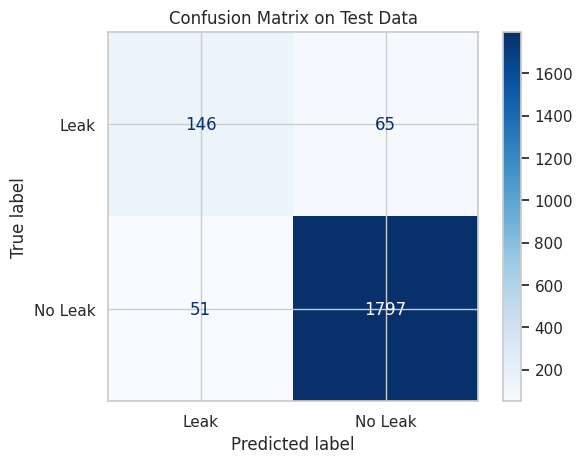

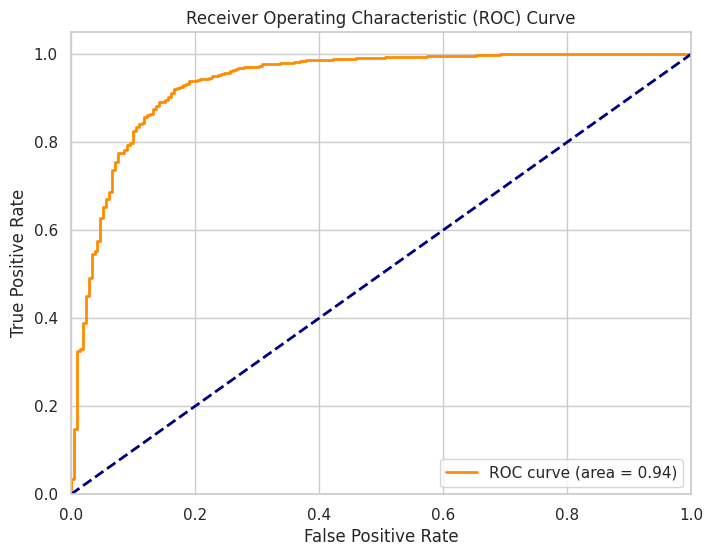

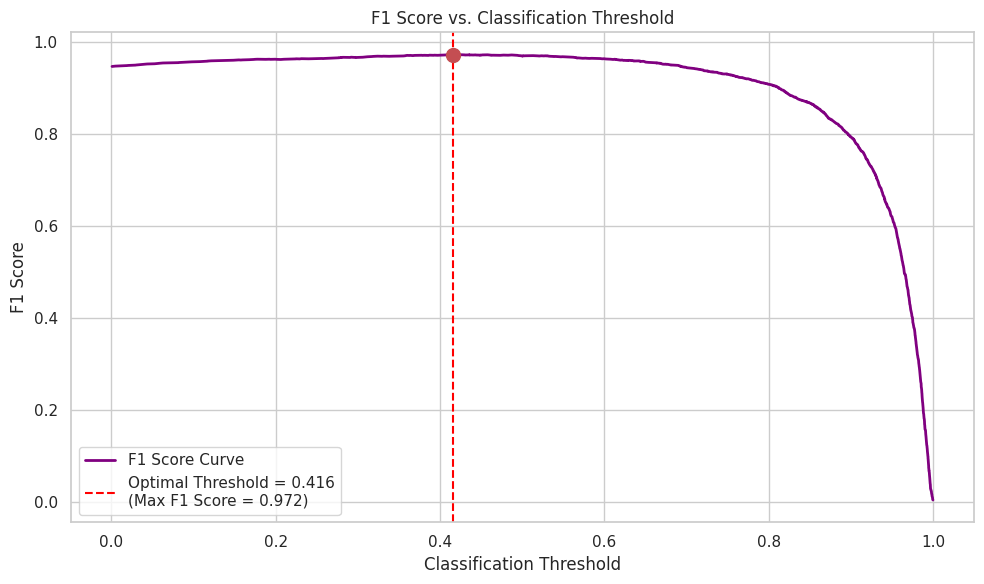

The optimal classification threshold is approximately 0.416, which yields an F1 score of 0.972.


In [ ]:
# Make predictions on the unseen test set
threshold_value = 0.416
y_scores = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_scores >= threshold_value).astype(int)

print("\n--- Final Evaluation on Test Set using Tuned Model ---")

# Print the classification report
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(2)
display(df_report)

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()

# Plot the ROC curve
test_roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the F1 curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = (2 * precision * recall) / (precision + recall)
f1_scores[np.isnan(f1_scores)] = 0

optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
optimal_f1 = f1_scores[optimal_threshold_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score Curve', color='purple', lw=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--',
            label=f'Optimal Threshold = {optimal_threshold:.3f}\n(Max F1 Score = {optimal_f1:.3f})')
plt.plot(optimal_threshold, optimal_f1, 'ro', markersize=10)
plt.xlabel('Classification Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"The optimal classification threshold is approximately {optimal_threshold:.3f}, which yields an F1 score of {optimal_f1:.3f}.")

Learning Curve Analysis

--- Generating Learning Curve ---


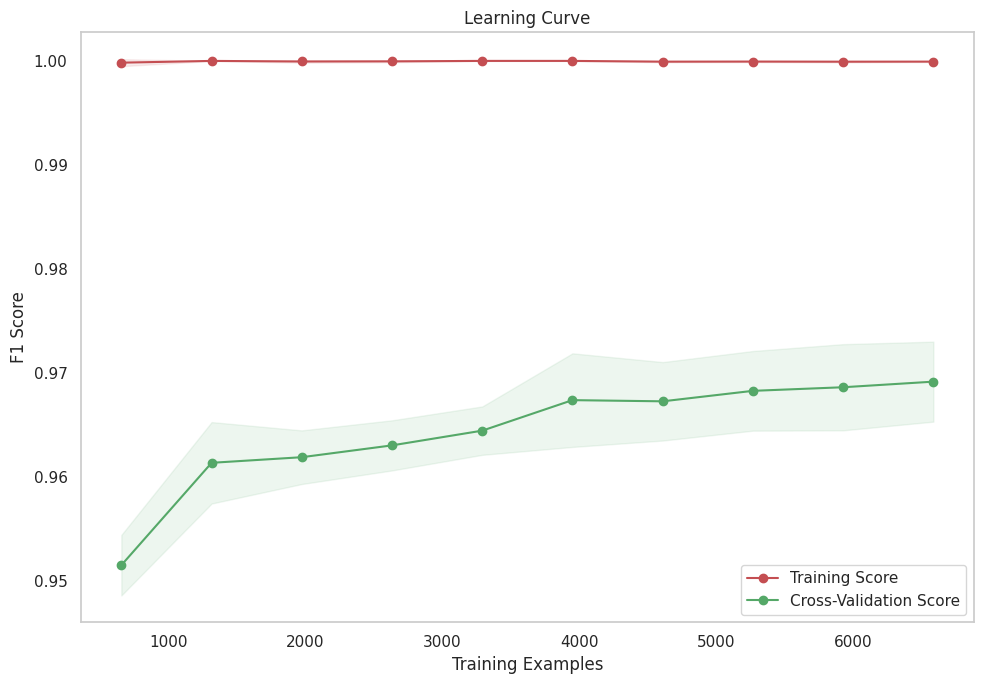


--- Interpreting the Learning Curve ---
1. If the training score is high and the cross-validation score is low, the model may have high variance (overfitting).
2. If both scores are low and close to each other, the model may have high bias (underfitting).
3. If both scores are high and converge as the training set size increases, the model is performing well.


In [40]:
from sklearn.model_selection import learning_curve

print("--- Generating Learning Curve ---")

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')

plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("\n--- Interpreting the Learning Curve ---")
print("1. If the training score is high and the cross-validation score is low, the model may have high variance (overfitting).")
print("2. If both scores are low and close to each other, the model may have high bias (underfitting).")
print("3. If both scores are high and converge as the training set size increases, the model is performing well.")